In [1]:
import pandas as pd
import io
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset 
import torch
import torch.nn as nn  # neural net layers and activations
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, Dataset 
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import torch.nn as nn

In [2]:
X = pd.read_csv('TrainData.csv', delimiter =',') #training data
y = pd.read_csv('selectivity.csv',delimiter=',') #true output labels, original

In [3]:
X.replace(0.1,0.0,inplace=True)
X.head()

,Elevation LB,Elevation UB,Aspect LB,Aspect UB,Slope LB,Slope UB,Horizontal_Distance_To_Hydrology LB,Horizontal_Distance_To_Hydrology UB,Vertical_Distance_To_Hydrology LB,Vertical_Distance_To_Hydrology UB,Horizontal_Distance_To_Roadways LB,Horizontal_Distance_To_Roadways UB,Hillshade_9am LB,Hillshade_9am UB,Hillshade_Noon LB,Hillshade_Noon UB,Hillshade_3pm LB,Hillshade_3pm UB,Horizontal_Distance_To_Fire_Points LB,Horizontal_Distance_To_Fire_Points UB
0,3396.0,3726.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2645.0,3033.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2131.0,3247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3625.0,3809.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3626.0,3642.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#convert to numpy arrays
X = X.values
y = y.values #uaing this for model training

In [5]:
X.shape

(20460, 20)

In [6]:
y.shape

(20460, 1)

In [7]:
epsilon = 1e-10
y_log = np.log2(y + epsilon) #log transofmration of the selectivity labels used during training.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state = 42) #testing 20%, trainig 80%

In [9]:
#convert the X features to float tensors for pytorch.
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [10]:
#converting selectivity, y labels to tensor
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [11]:
X_train.shape

torch.Size([16368, 20])

In [12]:
y_train.shape

torch.Size([16368, 1])

In [13]:
y_train = y_train.float()
y_test = y_test.float()

In [14]:
#Neural Network Model, 2 hidden layers.
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__() # instantiate nn model
        self.fc1 = nn.Linear(20, 140)
        self.fc2 = nn.Linear(140, 70)
        self.out = nn.Linear(70, 1)  # Output layer with single neuron

    def forward(self, x):
        print("Input shape:", x.shape)
        h1 = F.relu(self.fc1(x))
        print("Shape after fc1:", h1.shape)
        h2 = F.relu(self.fc2(h1))
        print("Shape after fc2:", h2.shape)
        output = self.out(h2)  # Linear activation for output layer
        print("Output shape:", output.shape)
        
        return output


In [15]:
#Neural Network Model with 3 hidden layers
class MyModel2(nn.Module):
    def __init__(self):
        super(MyModel2, self).__init__() # instantiate nn model
        self.fc1 = nn.Linear(20, 140)
        self.fc2 = nn.Linear(140, 70)
        self.fc3 = nn.Linear(70,35)
        self.out = nn.Linear(35, 1)  # Output layer with single neuron

    def forward(self, x):
        print("Input shape:", x.shape)
        h1 = F.relu(self.fc1(x))
        print("Shape after fc1:", h1.shape)
        h2 = F.relu(self.fc2(h1))
        print("Shape after fc2:", h2.shape)
        h3 = F.relu(self.fc3(h2))
        print("Shape after fc3:", h3.shape)
        output = self.out(h3)  # Linear activation for output layer
        print("Output shape:", output.shape)
        
        return output


In [16]:
#random seed
torch.manual_seed(40)
#create an instance of the 2 models
model = MyModel()
model2 = MyModel2()

In [17]:
#optimizer- wasn't specifically mentioned, popular methods are SGD ADAM,
#learning rate wasn't specified, going to keep it as 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()

In [ ]:
#train the model
#keep track of the losses since we want the model to decrease the losses overtime
epochs = 500
batch_size = 50
losses = []
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        #epoch_loss += loss.item() * inputs.size(0)  # Multiply by batch size to get total loss for the epoch
        epoch_loss += loss.item()/len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Batch Loss: {loss.item():.4f}')  # Print batch loss, not the overall loss
    epoch_loss /= len(train_loader.dataset)  # Calculate average loss per sample
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')  # Print epoch loss
    losses.append(epoch_loss)

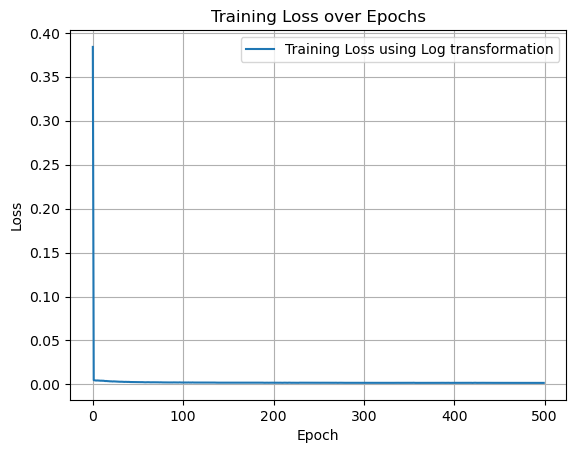

In [21]:
# Plot the loss values
import matplotlib.pyplot as plt

# Plot the loss values
plt.plot(range(epochs), losses, label='Training Loss using Log transformation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Input shape: torch.Size([4092, 20])
Shape after fc1: torch.Size([4092, 140])
Shape after fc2: torch.Size([4092, 70])
Output shape: torch.Size([4092, 1])
Test Loss: 37.23626708984375


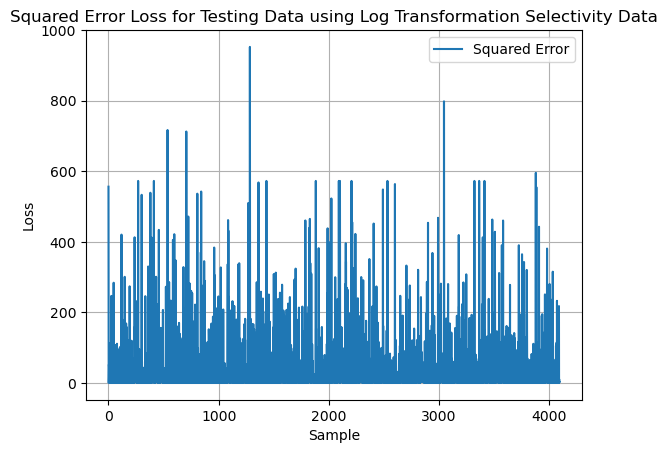

In [22]:
# Pass the testing data through the trained model to make predictions
with torch.no_grad():
    y_pred_test = model.forward(X_test)

# Compute the loss for the testing data
mse = nn.MSELoss()
test_loss = mse(y_pred_test, y_test)

# Print the test loss
print("Test Loss:", test_loss.item())

# Now, let's plot the loss
plt.figure()
plt.plot(range(len(y_test)), (y_pred_test - y_test)**2, label='Squared Error')
plt.xlabel('Sample')
plt.ylabel('Loss')
plt.title('Squared Error Loss for Testing Data using Log Transformation Selectivity Data')
plt.legend()
plt.grid(True)
plt.show()
